# Continuing analysis of shopping data

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## Read Inputs into data frame

In [2]:
order_products_train = pd.read_csv("order_products__train.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

Firstly, we examine the dataset i.e order_products__train and order_products__prior files. Based on the data exploration done earlier we already know that they have information related to which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [3]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


Next, we are going to concatenate these datasets in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers which will include all the data.

In [4]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


## Missing Data in all orders

We try to examine if we have any missing data in the dataset we are using.

In [5]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


From the above result, we observe is no missing data in order_products_all dataset

## Reorder Frequency

In [6]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

/Users/lalits/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


The above result shows that 59% of ordered products are previously ordered by customers.

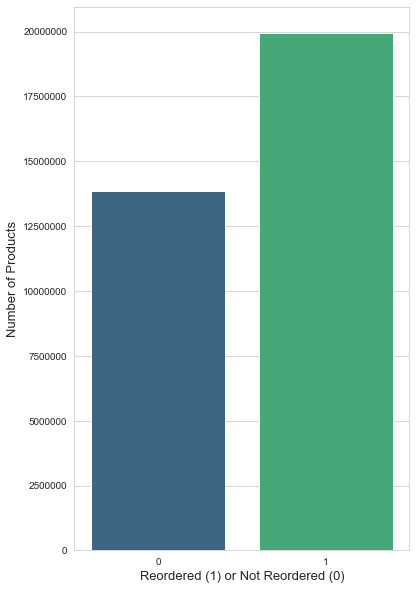

In [7]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(grouped.index, grouped.values, palette='viridis')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered (1) or Not Reordered (0)', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Predicting a user’s next order based on previously purchased products

Step 1: Importing the orders data.

In [8]:
orders_df = pd.read_csv("orders.csv", usecols=["order_id","user_id","order_number"])

As one of the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

Step 2: Creating data frame with old purchase

In [9]:
# Read the prior order file 
prior_df = pd.read_csv("order_products__prior.csv")

# Merge with the orders file to get the user_id 
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3
5,2,17794,6,1,202279,3
6,2,40141,7,1,202279,3
7,2,1819,8,1,202279,3
8,2,43668,9,0,202279,3
9,3,33754,1,1,205970,16


Step 3: Creating a data frame with latest purchase data

In [10]:
# Get the products and reorder status of the latest purchase of each user
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


Step 4: Counting of Number of reorders of customers

In [11]:
# get the count of each product and number of reorders by the customer 
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


Step 5: Merging the prior dataframe with latest dataframe

In [12]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


Next, we import the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

In [13]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv("order_products__train.csv", usecols=["order_id"])
train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


Step 6: Extract the distinct order ids in train_df. Then we will join the data frame with orders

In [14]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


Next, we join this with the Orders data frame

In [15]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [16]:
test_df = pd.read_csv("sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


Step 7 : Prepare test data frames

In [17]:
print(train_df.shape, test_df.shape)

(131209, 2) (75000, 2)


Step 8: Merging the train and test data with prior_df to extract the products purchased previously by the customer.

In [18]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [19]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")

test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0


In [20]:
products_df = pd.read_csv("products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


Step 9 : Adding more features to training data from Products data frame

In [21]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [22]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21


Since we have extracted all the products that has been purchased previously by the customer along with some features, we now use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [23]:
train_y_df = pd.read_csv("order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


In [24]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:
X=train_df.drop('reordered',axis=1)

In [26]:
X.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [27]:
Y =train_df['reordered']

In [28]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

Step 10: split data into train and test sets

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [59]:
model = XGBClassifier()

Step 11: Training and Testing the model using XGBClassifier

In [60]:
model.fit(X_train, y_train)

[19:03:16] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
y_pred = model.predict(X_test)

In [62]:
predictions = [round(value) for value in y_pred]

In [63]:
accuracy = accuracy_score(y_test, predictions)

### Accuracy for the  XGBoost Classifier

In [65]:
print("The accuracy of prediction usng XGBoost classifier: %.2f%%" % (accuracy * 100.0))

The accuracy of prediction usng XGBoost classifier: 90.43%


Step 12: Replacing Nan values with 0 in train and test dataset

In [66]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
3052321,2634088,11335,6873,1,0,0.0,83,4
5273294,3379345,104957,15923,1,0,0.0,67,20
6564246,1344587,174152,45692,1,0,0.0,107,19
7705447,2206969,196469,31205,1,0,0.0,26,7
6947171,1103780,57331,28599,1,0,0.0,130,14
...,...,...,...,...,...,...,...,...
1965286,1099888,79357,8277,9,8,0.0,24,4
4473121,256984,62140,42959,1,0,0.0,74,17
8158334,355337,70111,24341,1,0,0.0,31,7
6278263,1455864,170500,11097,1,0,0.0,30,6


# Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [69]:
#fitting the model
clf.fit(X_train, y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
#predictions
pred=clf.predict(X_test)

In [71]:
#accuracy score of Logistic Regression Model
print(accuracy_score(pred, y_test))

0.9019834165224757


### The accuracy of prediction using Logistic regression is 90.19%

# Random Forest 

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [74]:
clfrf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=24,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
#predictions
predrf=clfrf.predict(X_test)

In [76]:
#accuracy score for the random forest model
accuracy_score(predrf, y_test)

0.9044406517966745

### The accuracy of prediction using random forest is 90.45% 

# Light GBM

In [55]:
import lightgbm as lgb

In [52]:
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

In [53]:
model= lgb.LGBMClassifier()

In [54]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
pred=model.predict(X_test)

In [56]:
#Accuracy score of Light GBM
print(accuracy_score(pred, y_test))

0.9047006066925334


### The accuracy of prediction using Light Gradient based method is 90.47%

# K Nearest Neighbours

In [32]:
# Importing the KNeighborsClassifier 
from sklearn.neighbors import KNeighborsClassifier

In [33]:
# Instantiating the model
knn = KNeighborsClassifier(n_neighbors=5)

In [34]:
# Fitting the model with training data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [35]:
# Predicting the test data
pred = knn.predict(X_test)

In [47]:
# Printing the accuract of the knn model
print(accuracy_score(y_test, pred))

0.8936934656206968


# Choosing a K Value
- Let's go ahead and use the elbow method to pick a good K Value!

- Create a for loop that trains various KNN models with different k values, then keep track of the error_rate for each of these models with a list. Refer to the lecture if you are confused on this step.

In [50]:
# Defining an empty list to append the error rate values
error_rate = []


for i in range(1,30):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

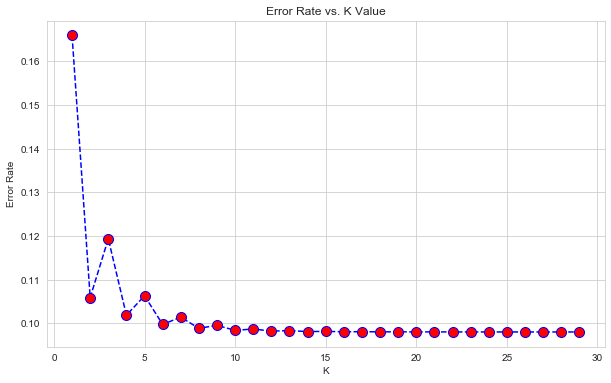

In [52]:
# Creating a plot to display the Error Rate vs K value
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

- We find that the Error rate remains relatively constant from k=10 to k=30

In [53]:
# Instantiating the KNeighboursClassifier with K=20
knn = KNeighborsClassifier(n_neighbors=20)

# Fitting the knn model
knn.fit(X_train,y_train)

# Predicting the test data
pred_i = knn.predict(X_test)

In [56]:
# Printing the accuracy of the model
print(accuracy_score(y_test, pred_i))

0.9019716166441217


### The accuracy of prediction using K Nearest Neighbours method is 90.197%

The text in the document is from source Instacart Kaggle Competition is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/
